In [8]:
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

data_path = Path('ReDWeb_V1/')

In [5]:
from torch.utils.data import Dataset
import cv2

class ReDWebDataset(Dataset):
    def __init__(self, rgb_paths, depth_paths, transform=None):
        self.rgb_paths = rgb_paths
        self.depth_paths = depth_paths
        self.transform = transform  

    def __len__(self):
        return len(self.rgb_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.rgb_paths[idx])
        depth = cv2.imread(self.depth_paths[idx], cv2.IMREAD_UNCHANGED)

        if self.transform:
            img, depth = self.transform(img, depth)
        return img, depth

In [6]:
filenames = os.listdir(data_path / 'Imgs')

images_filenames = [data_path / 'Imgs' / filename for filename in filenames]
depths_filenames = [data_path / 'RDs' / f"{filename.split('.')[0]}.png" for filename in filenames]

full_dataset = ReDWebDataset(images_filenames, depths_filenames)


Most common RGB resolutions (width, height):
  484x356: 20 images
  772x572: 8 images
  772x422: 5 images
  772x586: 5 images
  292x412: 4 images

Most common depth resolutions (width, height):
  484x356: 20 depth maps
  772x572: 8 depth maps
  772x422: 5 depth maps
  772x586: 5 depth maps
  292x412: 4 depth maps


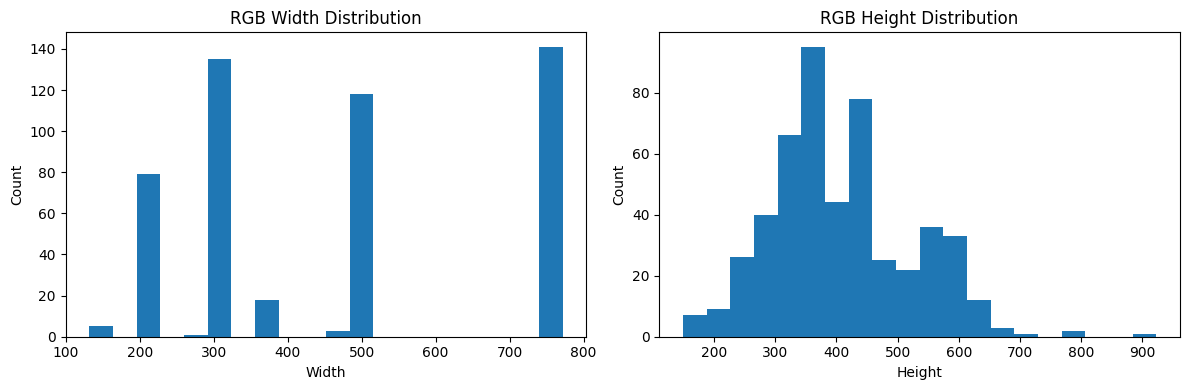

In [9]:
max_samples = min(500, len(full_dataset))
rgb_sizes = []
depth_sizes = []

for i in range(max_samples):
    img_path = images_filenames[i]
    depth_path = depths_filenames[i]

    img = cv2.imread(str(img_path))
    depth = cv2.imread(str(depth_path), cv2.IMREAD_UNCHANGED)

    if img is None or depth is None:
        continue

    rgb_sizes.append((img.shape[1], img.shape[0]))   # w, h
    depth_sizes.append((depth.shape[1], depth.shape[0]))

rgb_counter = Counter(rgb_sizes)
depth_counter = Counter(depth_sizes)

print("\nMost common RGB resolutions (width, height):")
for (w, h), c in rgb_counter.most_common(5):
    print(f"  {w}x{h}: {c} images")

print("\nMost common depth resolutions (width, height):")
for (w, h), c in depth_counter.most_common(5):
    print(f"  {w}x{h}: {c} depth maps")

rgb_widths  = [w for w, h in rgb_sizes]
rgb_heights = [h for w, h in rgb_sizes]

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(rgb_widths, bins=20)
plt.title("RGB Width Distribution")
plt.xlabel("Width")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(rgb_heights, bins=20)
plt.title("RGB Height Distribution")
plt.xlabel("Height")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


Depth value stats (non-zero):
  Min:  1.0000
  Max:  255.0000
  Mean: 166.0247
  Std:  70.6918


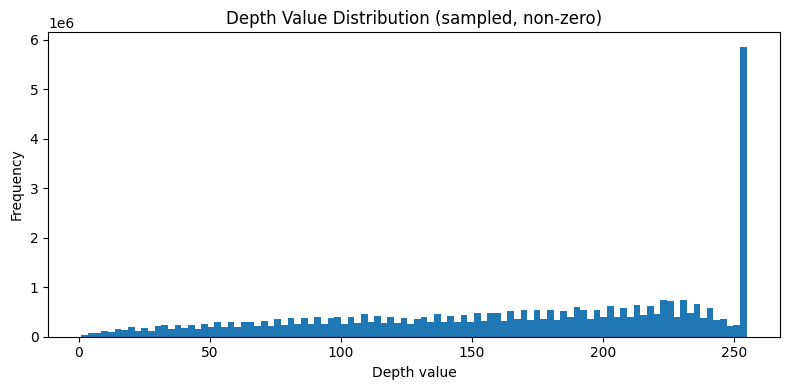

In [10]:
depth_values_sampled = []

max_depth_samples = min(200, len(full_dataset))
for i in range(max_depth_samples):
    depth = cv2.imread(str(depths_filenames[i]), cv2.IMREAD_UNCHANGED)
    if depth is None:
        continue

    vals = depth.flatten()
    vals = vals[vals > 0]
    if vals.size > 0:
        depth_values_sampled.append(vals)

if depth_values_sampled:
    depth_values = np.concatenate(depth_values_sampled)

    print("\nDepth value stats (non-zero):")
    print(f"  Min:  {depth_values.min():.4f}")
    print(f"  Max:  {depth_values.max():.4f}")
    print(f"  Mean: {depth_values.mean():.4f}")
    print(f"  Std:  {depth_values.std():.4f}")

    plt.figure(figsize=(8,4))
    plt.hist(depth_values, bins=100)
    plt.title("Depth Value Distribution (sampled, non-zero)")
    plt.xlabel("Depth value")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

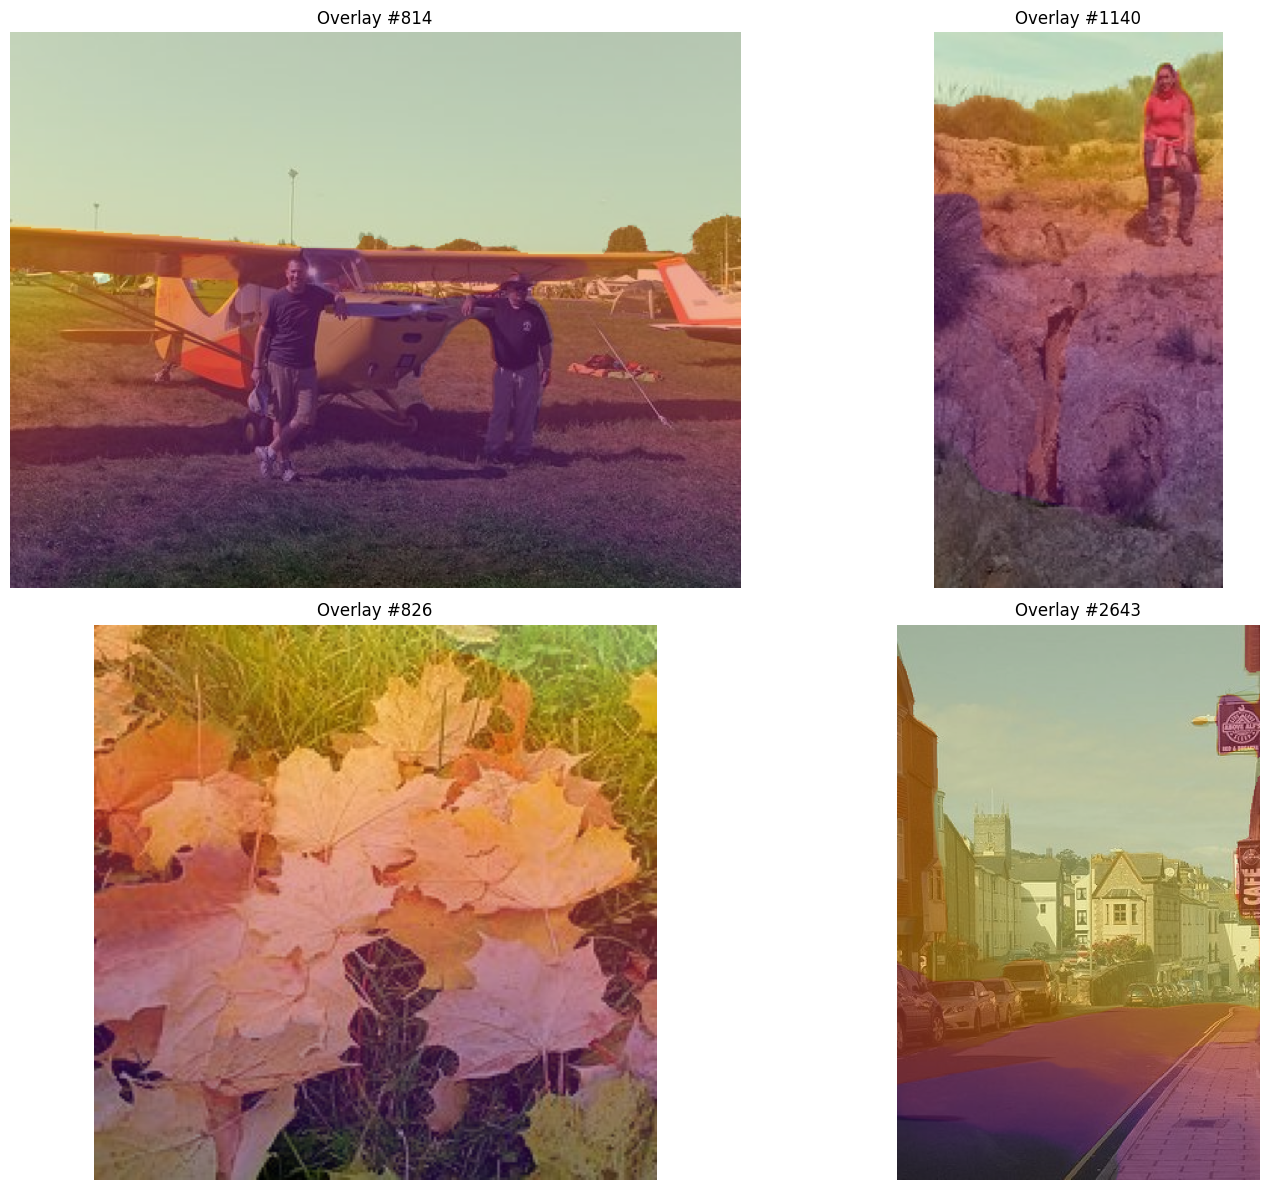

In [15]:
import random

def load_pair(idx):
    img = cv2.imread(str(images_filenames[idx]))
    depth = cv2.imread(str(depths_filenames[idx]), cv2.IMREAD_UNCHANGED)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_rgb, depth

def overlay_depth_grid(num_samples=4, alpha=0.5):
    indices = random.sample(range(len(full_dataset)), num_samples)

    plt.figure(figsize=(16, 12))

    for i, idx in enumerate(indices):
        img_rgb, depth = load_pair(idx)

        # Resize
        if depth.shape[:2] != img_rgb.shape[:2]:
            depth_resized = cv2.resize(
                depth, (img_rgb.shape[1], img_rgb.shape[0]),
                interpolation=cv2.INTER_NEAREST
            )
        else:
            depth_resized = depth

        # Normalize
        depth_norm = depth_resized.astype(np.float32)
        if depth_norm.max() > 0:
            depth_norm /= depth_norm.max()

        plt.subplot(2, 2, i + 1)
        plt.imshow(img_rgb)
        plt.imshow(depth_norm, cmap='inferno', alpha=alpha)
        plt.title(f"Overlay #{idx}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Run it
overlay_depth_grid(num_samples=4, alpha=0.5)


Depth edge vs RGB edge example:


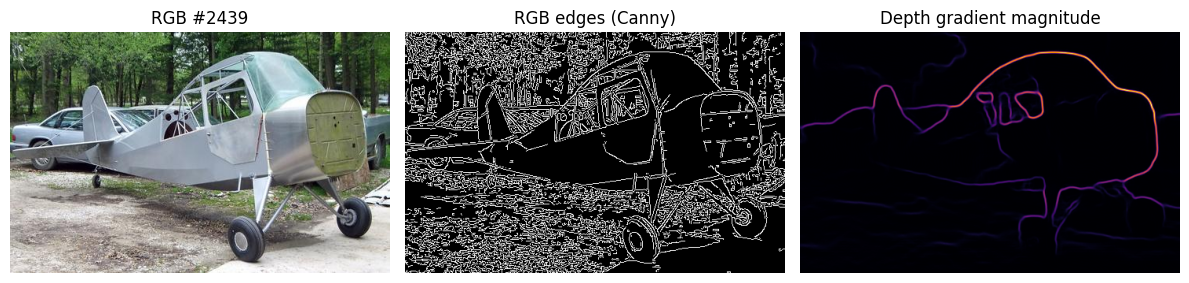

In [18]:
def show_depth_edges(idx):
    img_rgb, depth = load_pair(idx)
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    if depth.shape[:2] != gray.shape[:2]:
        depth = cv2.resize(depth, (gray.shape[1], gray.shape[0]),
                           interpolation=cv2.INTER_NEAREST)


    edges_rgb = cv2.Canny(gray, 100, 200)
    depth_float = depth.astype(np.float32)
    depth_float[depth_float <= 0] = 0
    dx = cv2.Sobel(depth_float, cv2.CV_32F, 1, 0, ksize=3)
    dy = cv2.Sobel(depth_float, cv2.CV_32F, 0, 1, ksize=3)
    mag = np.sqrt(dx**2 + dy**2)

    # Normalize
    if mag.max() > 0:
        mag_vis = (mag / mag.max() * 255).astype(np.uint8)
    else:
        mag_vis = mag.astype(np.uint8)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img_rgb)
    plt.title(f"RGB #{idx}")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(edges_rgb, cmap="gray")
    plt.title("RGB edges (Canny)")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(mag_vis, cmap="inferno")
    plt.title("Depth gradient magnitude")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

print("Depth edge vs RGB edge example:")
show_depth_edges(random.randint(0, len(full_dataset) - 1))
